In [ ]:
import numpy as np
import scipy.interpolate as si
import matplotlib.pyplot as plt

### Fit Points From Control Points
Uses scipy to get a list of fit points given control points, degree, and interval. We used degree=5 for all of our airfoils. 

In [ ]:
def scipy_bspline(cv, n=100, degree=3, periodic=False):
    """ Calculate n samples on a bspline

        cv :      Array ov control vertices
        n  :      Number of samples to return
        degree:   Curve degree
        periodic: True - Curve is closed
    """
    cv = np.asarray(cv)
    count = cv.shape[0]

    # Closed curve
    if periodic:
        kv = np.arange(-degree,count+degree+1)
        factor, fraction = divmod(count+degree+1, count)
        cv = np.roll(np.concatenate((cv,) * factor + (cv[:fraction],)),-1,axis=0)
        degree = np.clip(degree,1,degree)

    # Opened curve
    else:
        degree = np.clip(degree,1,count-1)
        kv = np.clip(np.arange(count+degree+1)-degree,0,count-degree)
    print(kv)
    # Return samples
    max_param = count - (degree * (1-periodic))
    spl = si.BSpline(kv, cv, degree)
    return spl(np.linspace(0,max_param,n))

### Read in Control Points From .txt File
Reads in control points from a .txt file and generates an array of np.arrays representing the control points for each spline. Works for any number of splines and removes overlapping points. 

In [34]:
import numpy as np

def control_points(file_path):
    splines = []
    cur_spline = []

    with open(file_path, 'r') as file:
        for line in file:
            if line.strip() == 'START':
                if cur_spline:
                    splines.append(np.array(cur_spline))
                    cur_spline = []
            elif line.strip() == 'END':
                continue
            else:
                values = list(map(float, line.split()))
                cur_spline.append(values[:2])

    if cur_spline:
        splines.append(np.array(cur_spline))
    
    # Removes last coordinate of each spline as this is repeated 
    splines = [spline[:-1] for spline in splines]
    return splines

# Example usage
file_path = 'ControlPoints.txt'  # Replace with the path to your file
splines_list = read_file(file_path)

### Get and Plot Fitpoints
get_fitpoints() takes an array of splines (as control points) returns a flattened list of fitpoints as a list of points as tuples

plot_fitpoints() takes an array of splines (as control points) and plots the resulting fitted points with the optional paramater show_points to display the control points

In [90]:
# Returns flattened list of fitpoints as a list of tuple-points
def get_fitpoints(splines):
    points = []
    for s in splines:
        points.append(scipy_bspline(s, n=50, degree=5, periodic=False))
        
    tuples = []
    for spline in points:
        flattened_points = spline.reshape(-1, 2).tolist()
        flattened_tuples = [tuple(point) for point in flattened_points]
        tuples.append(flattened_tuples)
    tuples = [point for tup in tuples for point in tup]
    
    return tuples  

[0 0 0 0 0 0 1 1 1 1 1 1]
[0 0 0 0 0 0 1 1 1 1 1 1]
[0 0 0 0 0 0 1 1 1 1 1 1]


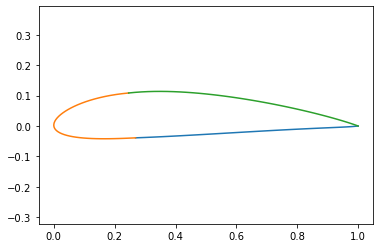

In [115]:
def plot_fitpoints(splines, show_points=True):
    for s in splines: 
        if show_points == True:
            plt.plot(s[:,0],s[:,1], 'o--', label='Control Points')
        p = scipy_bspline(s, n=50, degree=5, periodic=False)
        x,y = p.T
        # Setting equal aspect ratio for both axes to avoid distortion
        plt.axis('equal')
        plt.plot(x,y,)
        
        
plot_fitpoints(splines_list, show_points=False)


### Calculate Non-Overlapping area and Plot Polygons
non_overlapping_area() does as the name suggests. It takes two lists of points representing two polygons and returns the non-overlapping area of the two polygons. 

plot_polygon() takes an ax, set of points, and a label and plots the polygon represented by the points. It has the optional parameter "fill" which shades in the area represented by the set of points. This can be used to represent the intersection of two polygons

In [129]:
from shapely.geometry import Polygon
from shapely.ops import unary_union

def non_overlapping_area(poly1_points, poly2_points):
    poly1 = Polygon(poly1_points)
    poly2 = Polygon(poly2_points)

    intersection = poly1.intersection(poly2)

    if intersection.is_empty:
        return poly1.union(poly2).area
    else:
        return poly1.union(poly2).area - intersection.area
    
def plot_polygon(ax, points, label, fill=False):
    if fill == True:
        x, y = zip(*points)
        plt.fill(x, y, alpha=0.5, label=label)
        ax.set_aspect('equal', adjustable='datalim')
        ax.legend()
        
    else:
        poly = Polygon(points)
        x, y = poly.exterior.xy
        ax.plot(x, y, label=label)
        ax.set_aspect('equal', adjustable='datalim')
        ax.legend()

[0 0 0 0 0 0 1 1 1 1 1 1]
[0 0 0 0 0 0 1 1 1 1 1 1]
[0 0 0 0 0 0 1 1 1 1 1 1]
Non-overlapping area: 0.6029518722875568


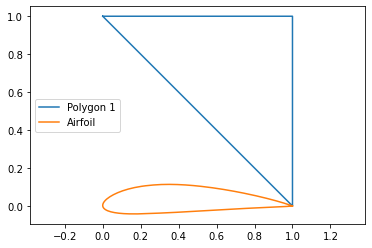

In [133]:
# Example usage
poly1_points = [(0, 1), (0, 1), (1, 1), (1, 0)]
airfoil_points = get_fitpoints(splines_list)

result = non_overlapping_area(poly1_points, airfoil_points)
print(f"Non-overlapping area: {result}")

fig, ax = plt.subplots()
plot_polygon(ax, poly1_points, 'Polygon 1')
plot_polygon(ax, airfoil_points, 'Airfoil')


In [141]:
square1 = [(0, 0), (0, 1), (1, 1), (1, 0), (0.5, 0)]
square2 = [(0, 1), (0, 1), (1, 1), (1, 0)]
point = [(0, 0), (0, 0), (0, 0)]
print(non_overlapping_area(square1, point))


1.0


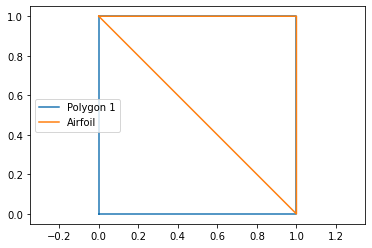

In [135]:
fig, ax = plt.subplots()
plot_polygon(ax, square1, 'Polygon 1')
plot_polygon(ax, square2, 'Airfoil')
